In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

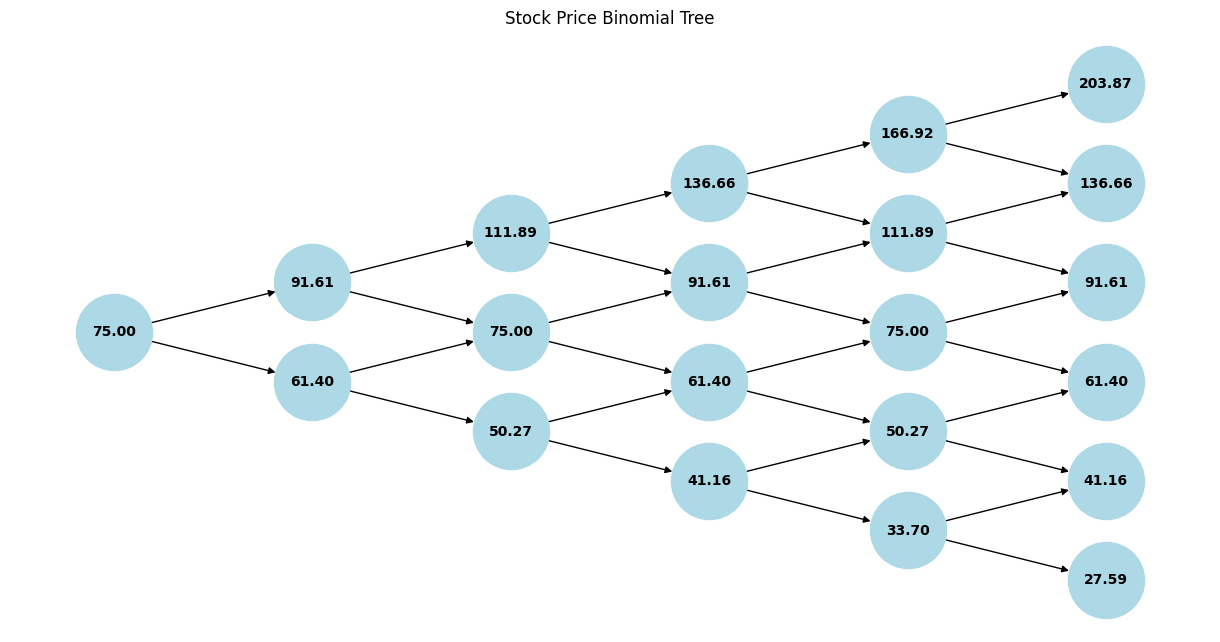

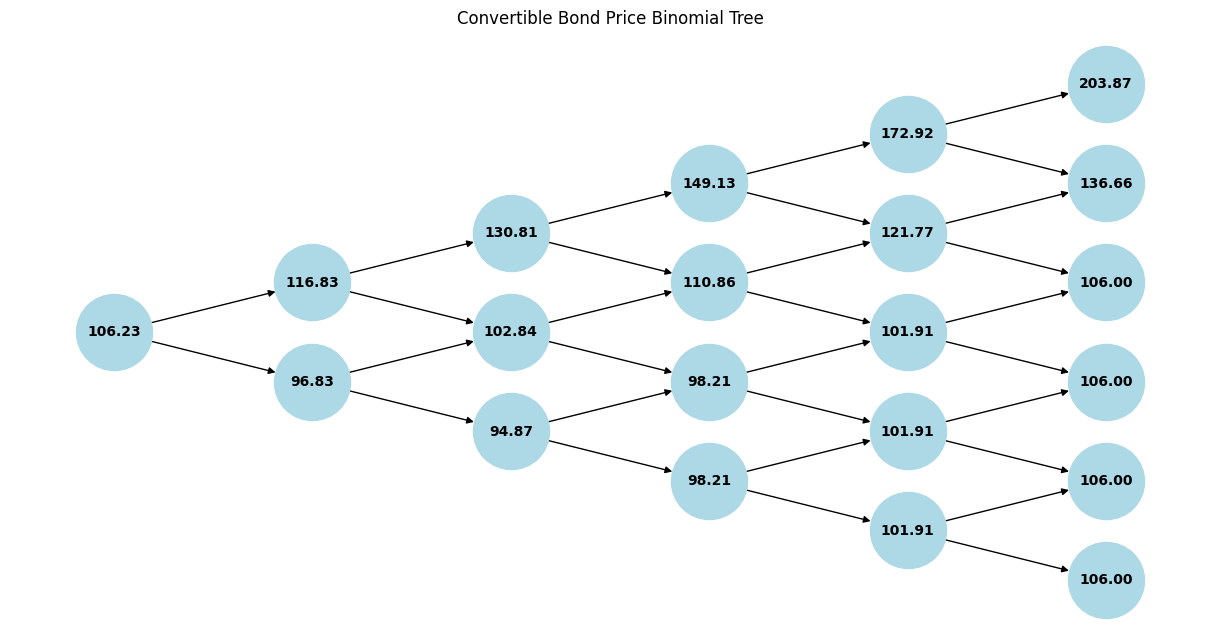

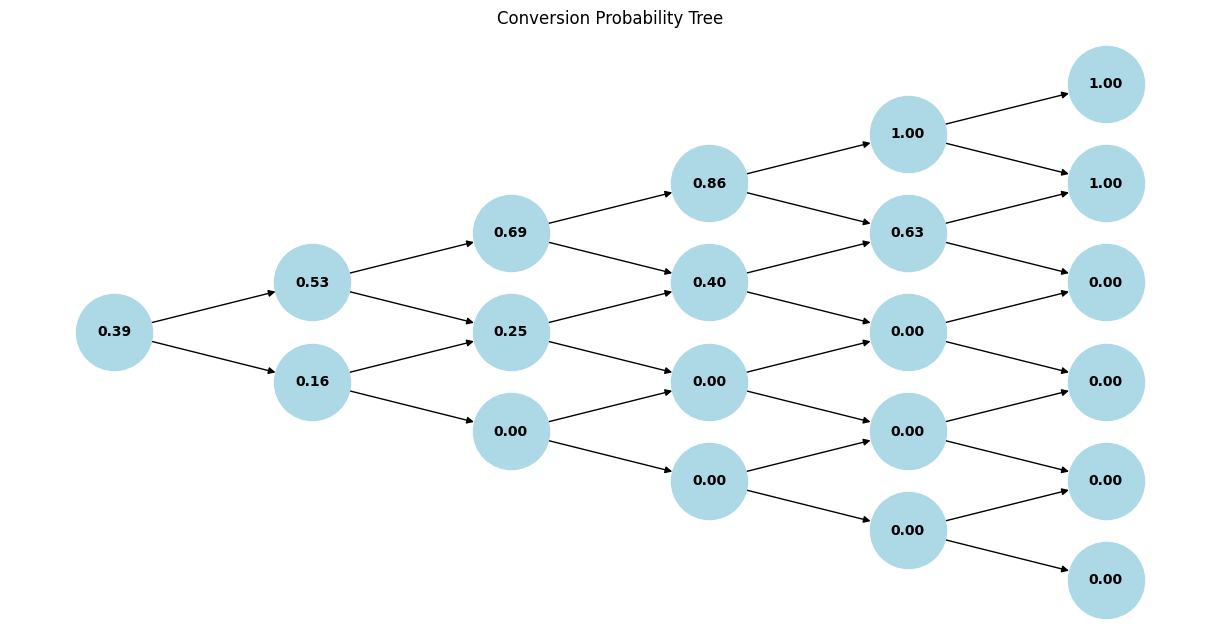

In [2]:
# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, conversion_ratio, N, sigma, AmeEur='e'):
    # Time step
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))     # Up factor
    d = 1 / u                           # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Create the binomial stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    BondPrice = np.zeros((N + 1, N + 1))
    # Create the conversion probability tree
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(N + 1):
        stock_price = StockPrice[j, N]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        BondPrice[j, N] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        ConversionProbability[j, N] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(N - 1, -1, -1):
        if CouponTime != (T - np.ceil((N - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((N - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = StockPrice[j, i]

            # Dynamic discount factors (ru, rd)
            ru = ConversionProbability[j+1, i+1] * r + (1 - ConversionProbability[j+1, i+1]) * (r + k)
            rd = ConversionProbability[j, i+1] * r + (1 - ConversionProbability[j, i+1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            # Calculate bond price using backward induction
            hold_bond_value = CouponValue + p * BondPrice[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * BondPrice[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Modify for American or European option style
            if AmeEur == 'a':
                # American style: check for early exercise
                BondPrice[j, i] = max(hold_bond_value, convert_to_stock_value)
            else:
                # European style: only exercise at maturity
                BondPrice[j, i] = hold_bond_value

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if BondPrice[j, i] == convert_to_stock_value and AmeEur == 'a':
                ConversionProbability[j, i] = 1
            else:
                ConversionProbability[j, i] = p * ConversionProbability[j + 1, i + 1] + (1 - p) * ConversionProbability[j, i + 1]

    return StockPrice, BondPrice, ConversionProbability

# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}
    
    # Define the horizontal offset to center the nodes at each level
    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    # Plot
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

# Parameters
S0 = 75                             # Initial stock price
F = 100                             # Face value of the bond
X = 100                             # Strike price for conversion
T = 5                               # Time to maturity (in years)
r = 0.07                            # Risk-free rate
q = 0
b = r - q
k = 0.03                            # Credit spread
sigma = 0.2                         # Volatility
dt = 1
coupon = 6                          # Coupon payment per year
m = 1                               # Conversion ratio (1 bond = 1 stock)
N = 5                               # Number of time steps
conversion_ratio = F / X            # Conversion ratio

# Calculate the binomial trees
StockPrice, BondPrice, ConversionProbability = CRR_convertible_bond(S0, F, T, r, k, coupon, m, N, sigma)

# Plot the stock price tree
plot_binomial_tree(StockPrice, "Stock Price Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(BondPrice, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(ConversionProbability, "Conversion Probability Tree")



=== Model: CRR ===
Model: CRR, u: 1.2214, d: 0.8187, p: 0.6302


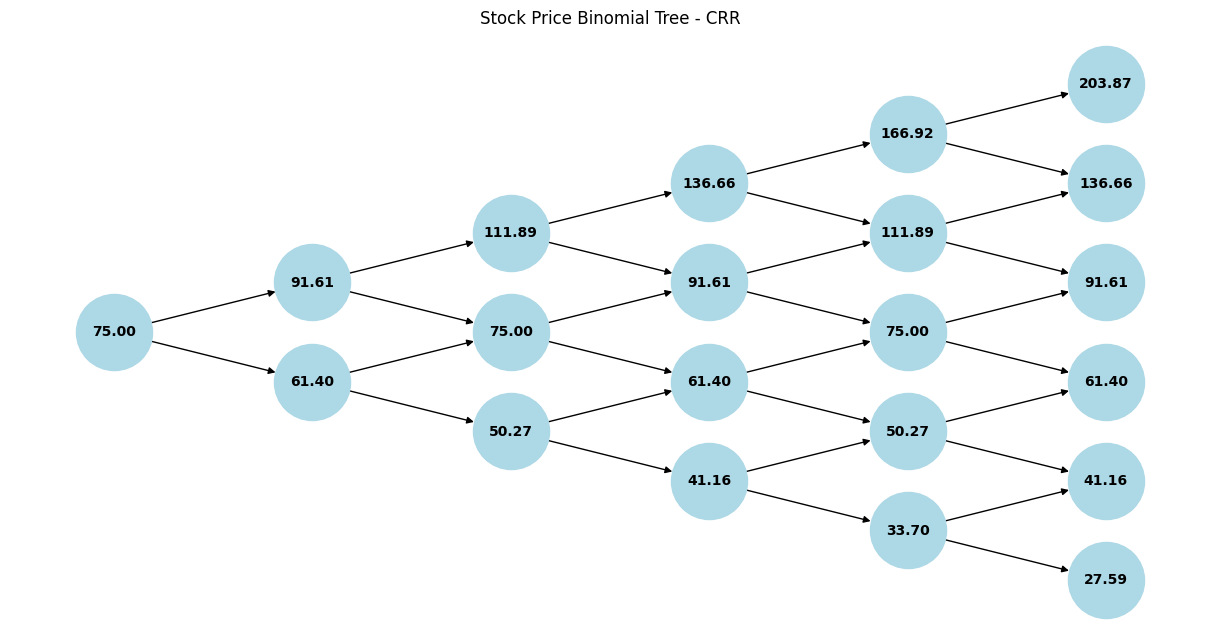

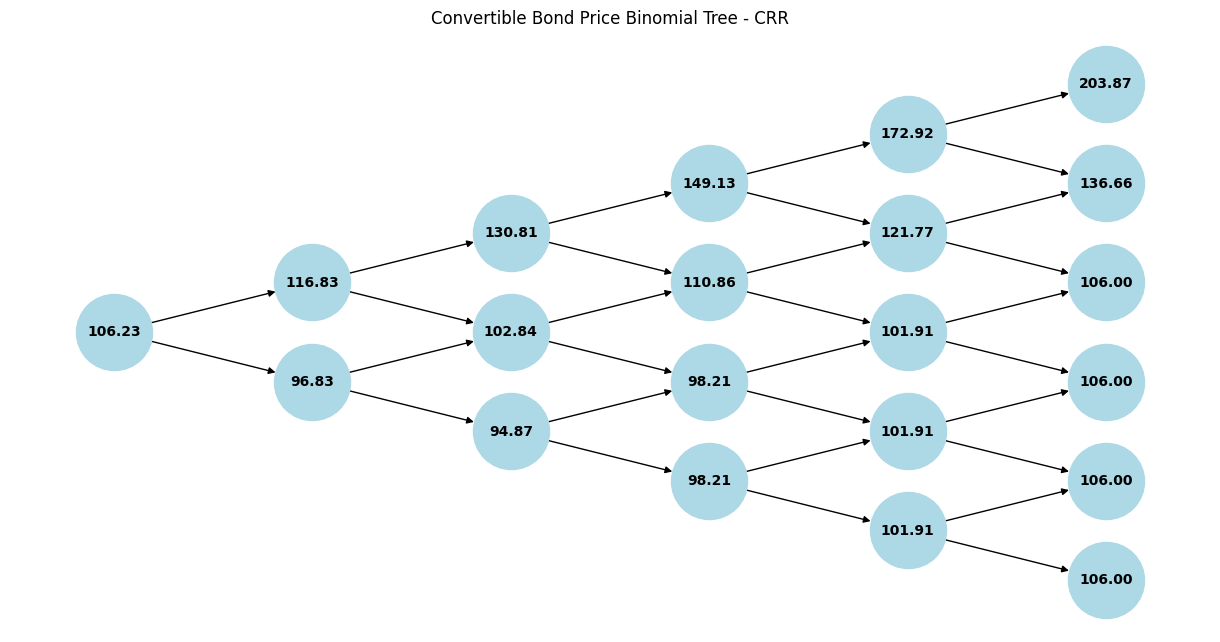

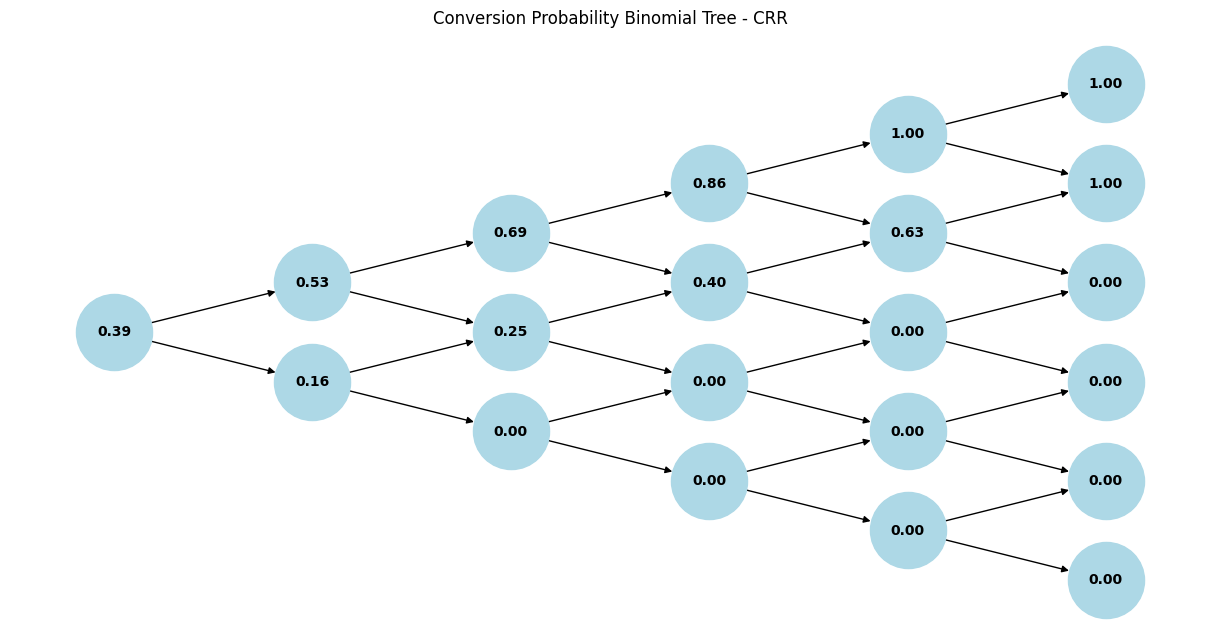


=== Model: Jarrow-Rudd ===
Model: Jarrow-Rudd, u: 1.2840, d: 0.8607, p: 0.5000


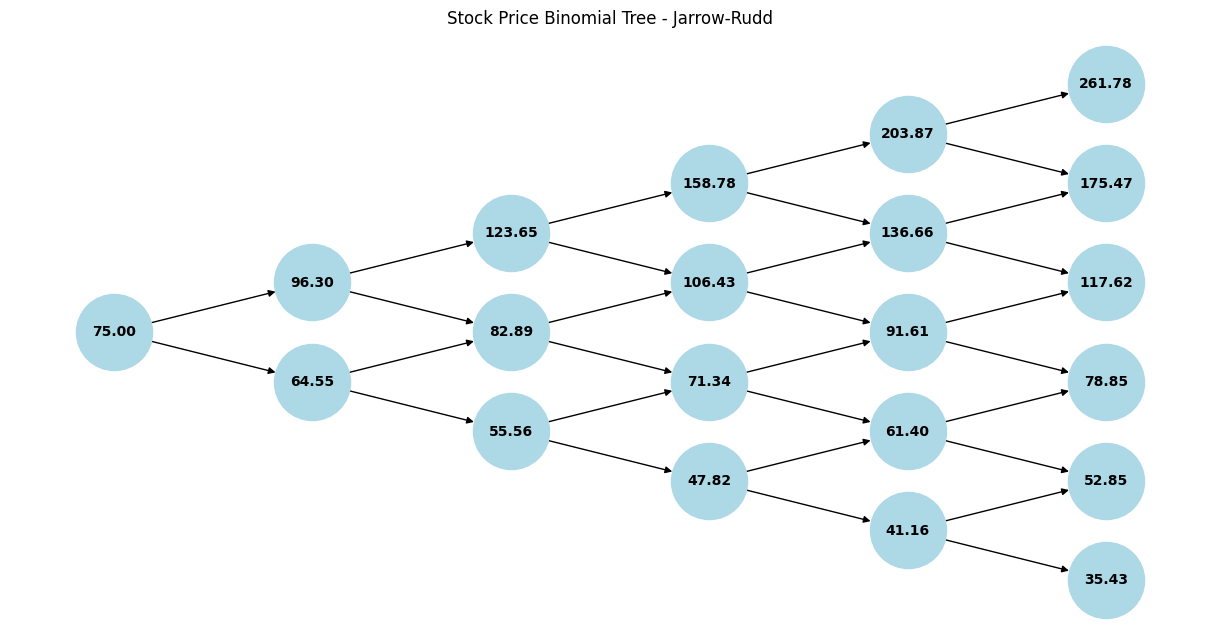

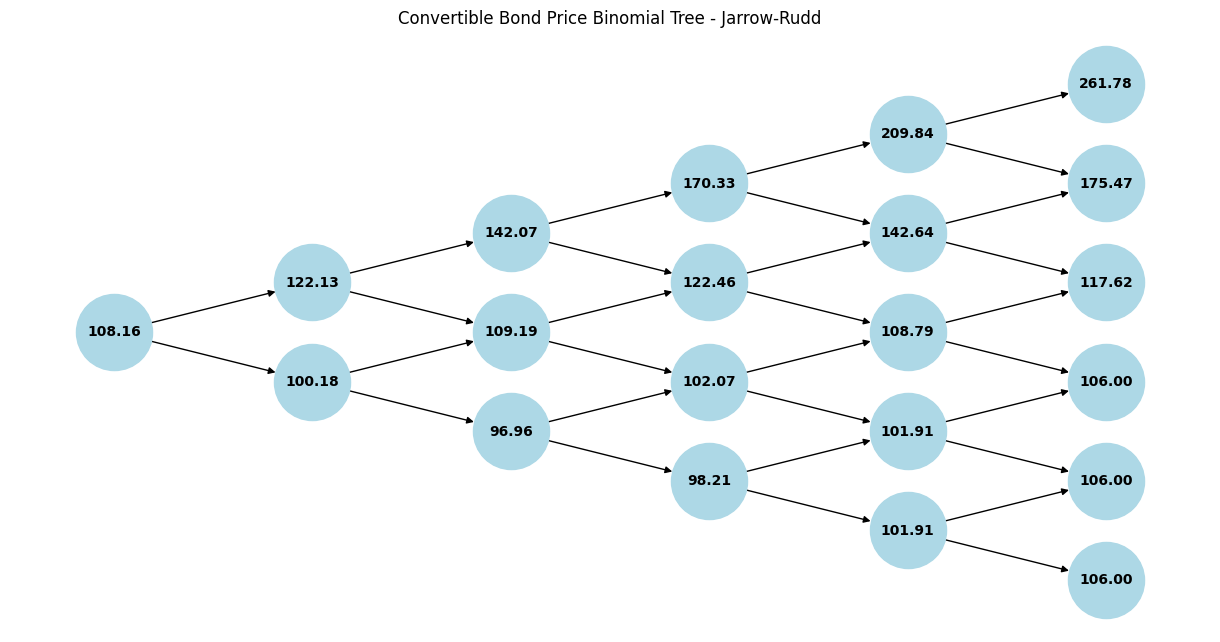

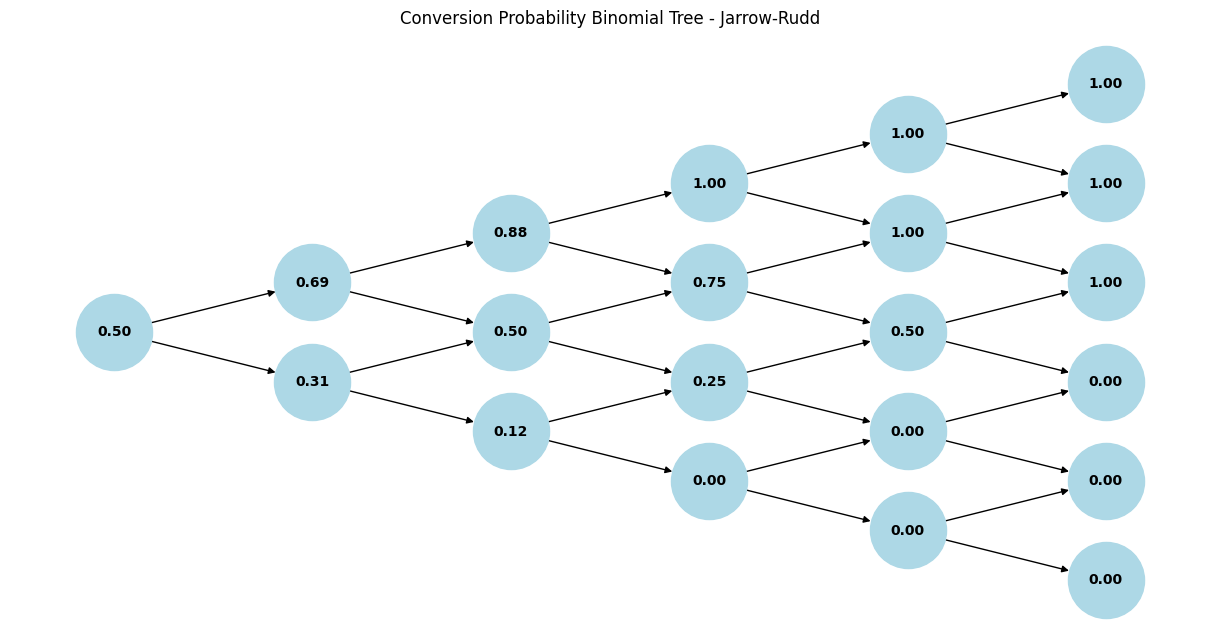


=== Model: Tian ===
Model: Tian, u: 1.3657, d: 0.9124, p: 0.3532


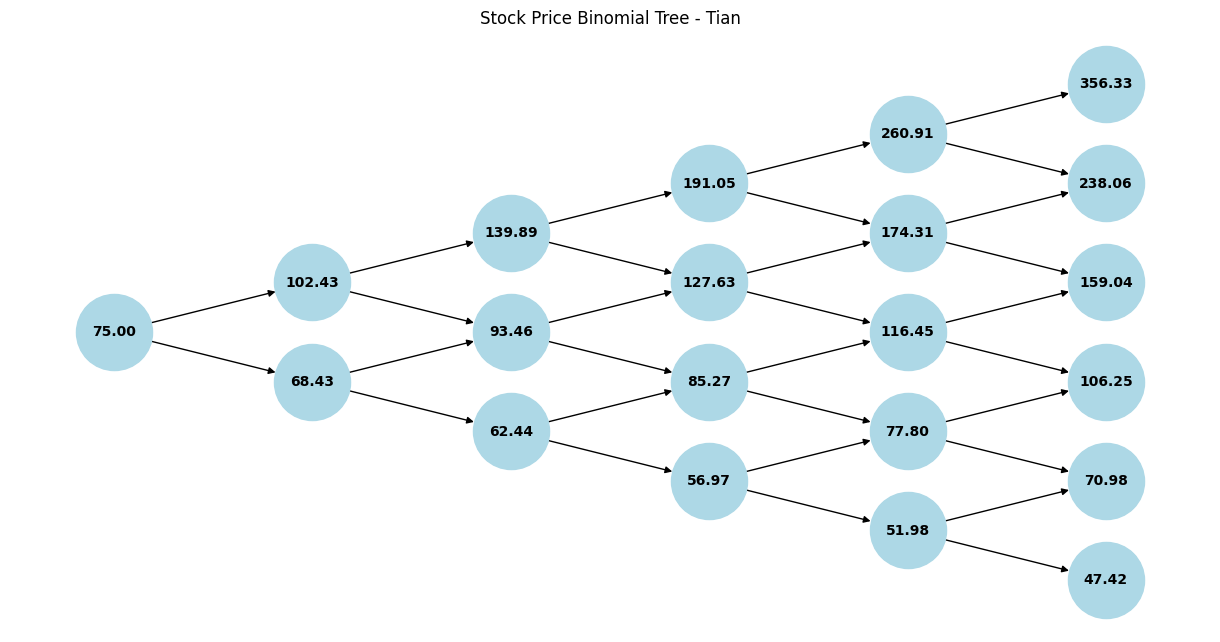

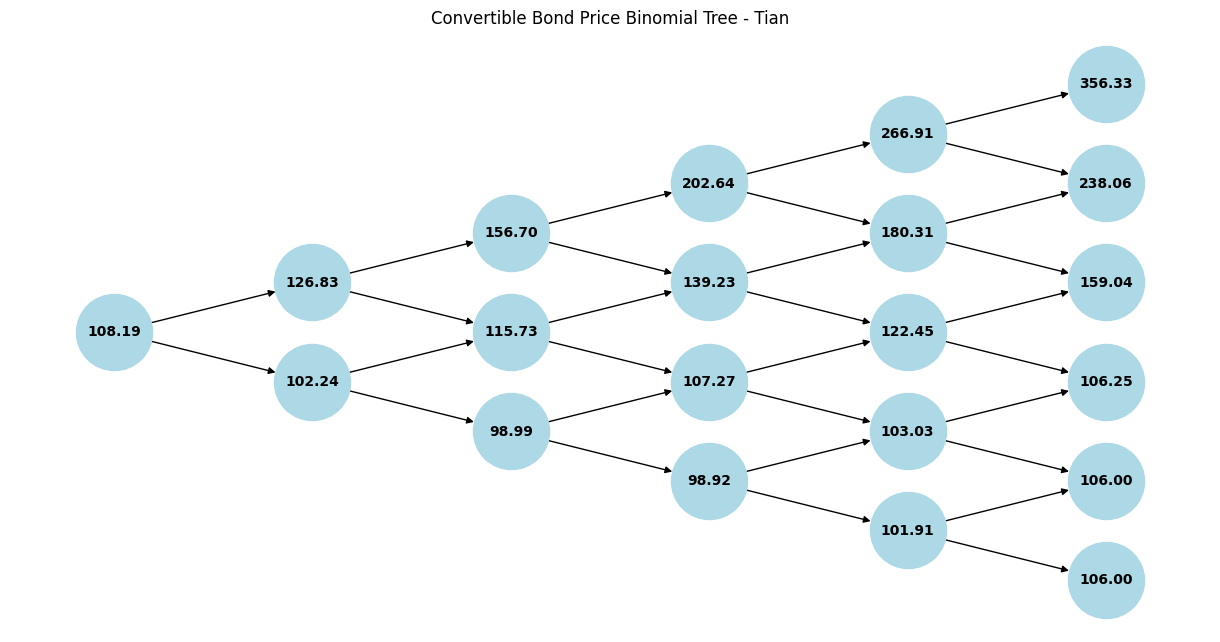

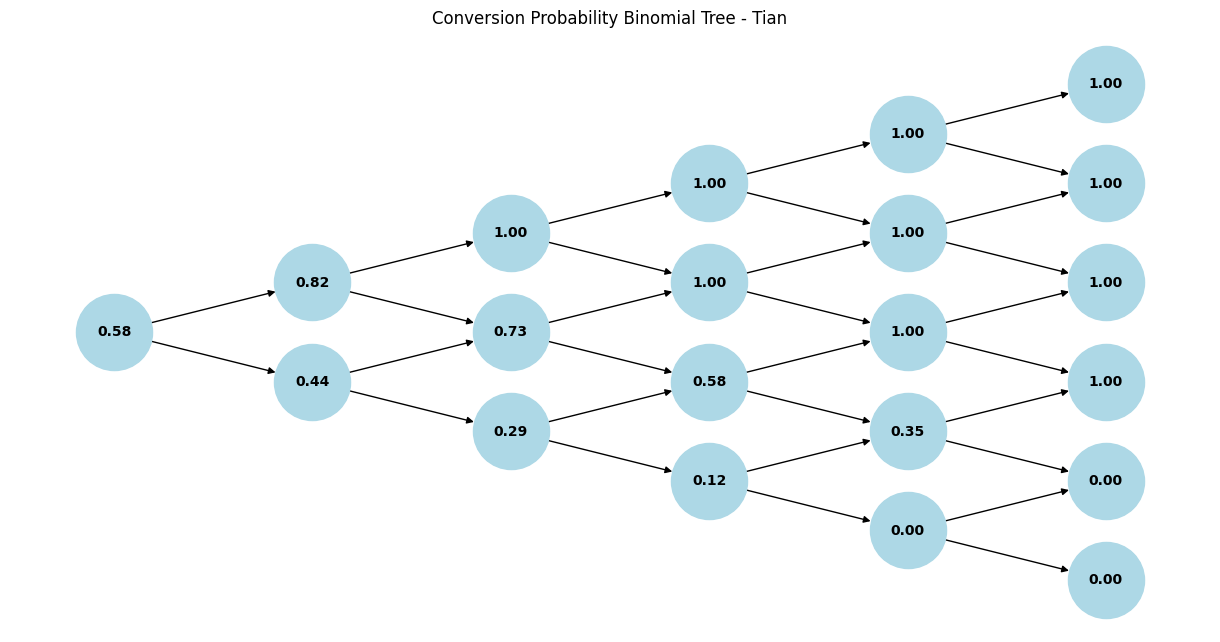


=== Model: CRR_Drift ===
Model: CRR_Drift, u: 1.2214, d: 0.8187, p: 0.6302


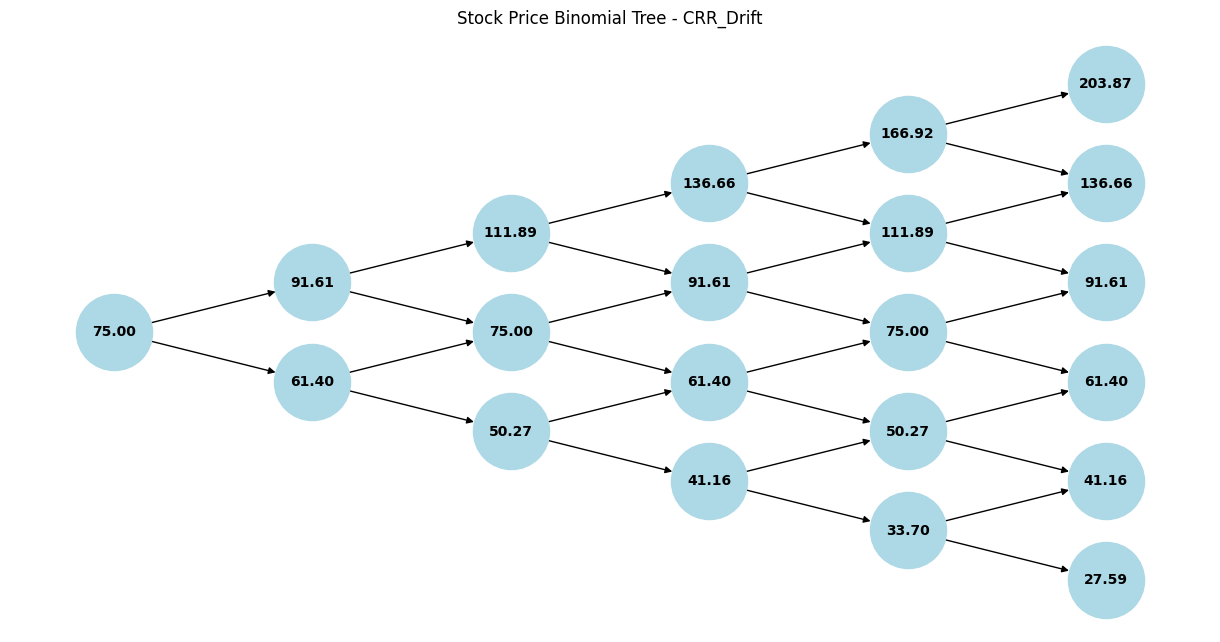

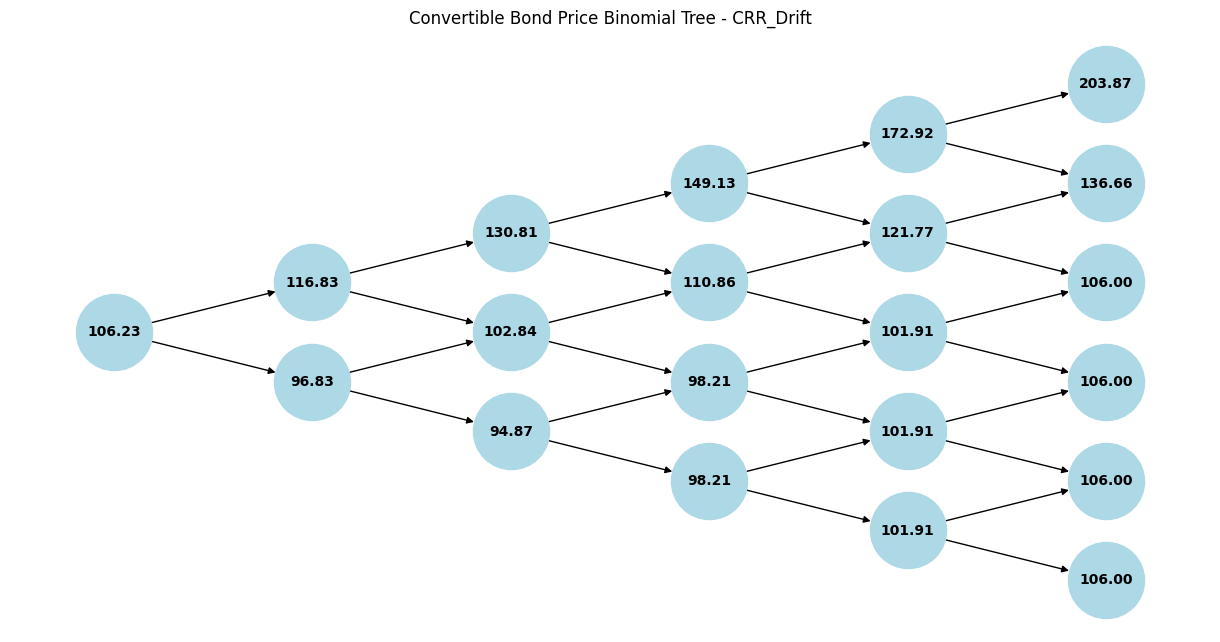

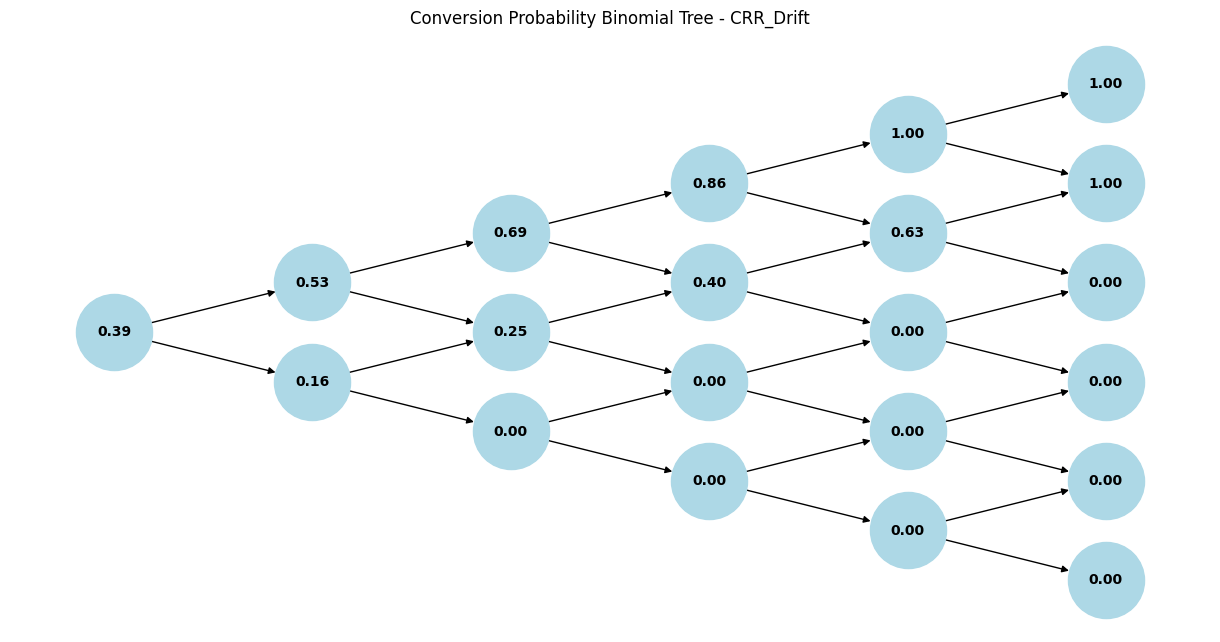


=== Model: Haahtela ===
Model: Haahtela, u: 1.2892, d: 0.8558, p: 0.5000


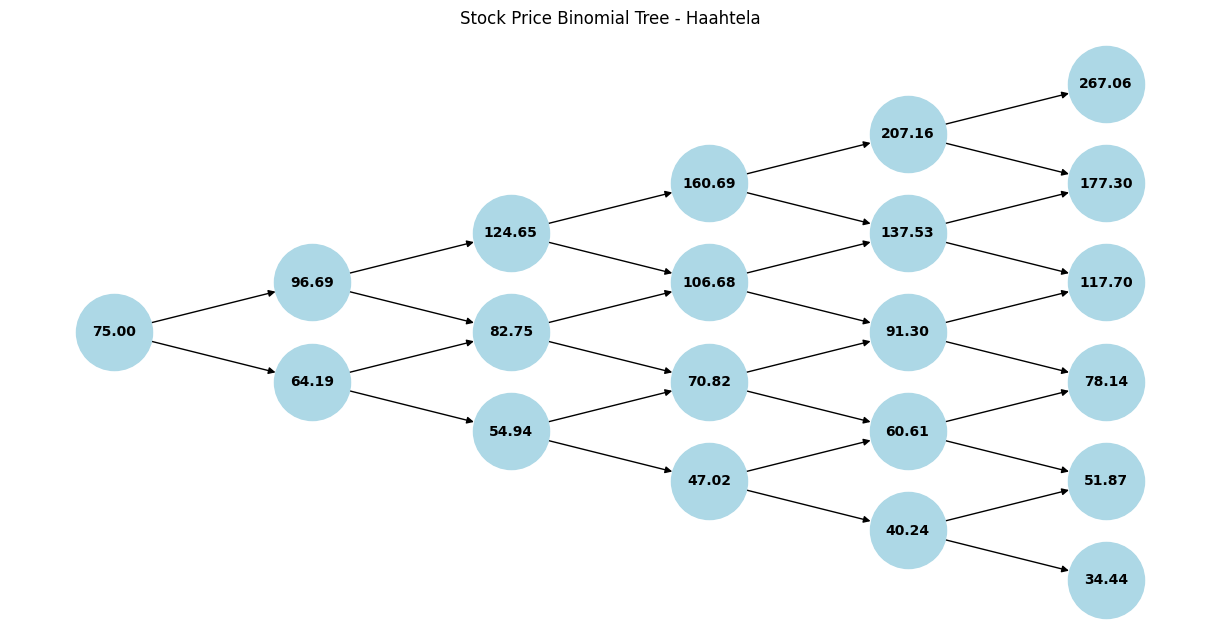

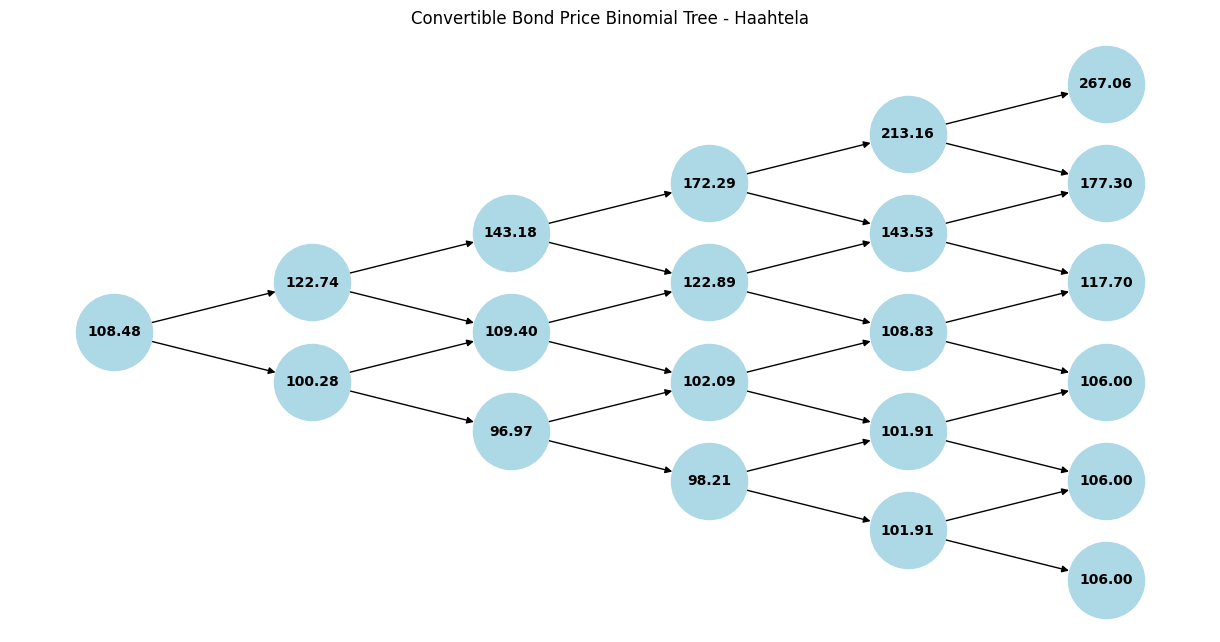

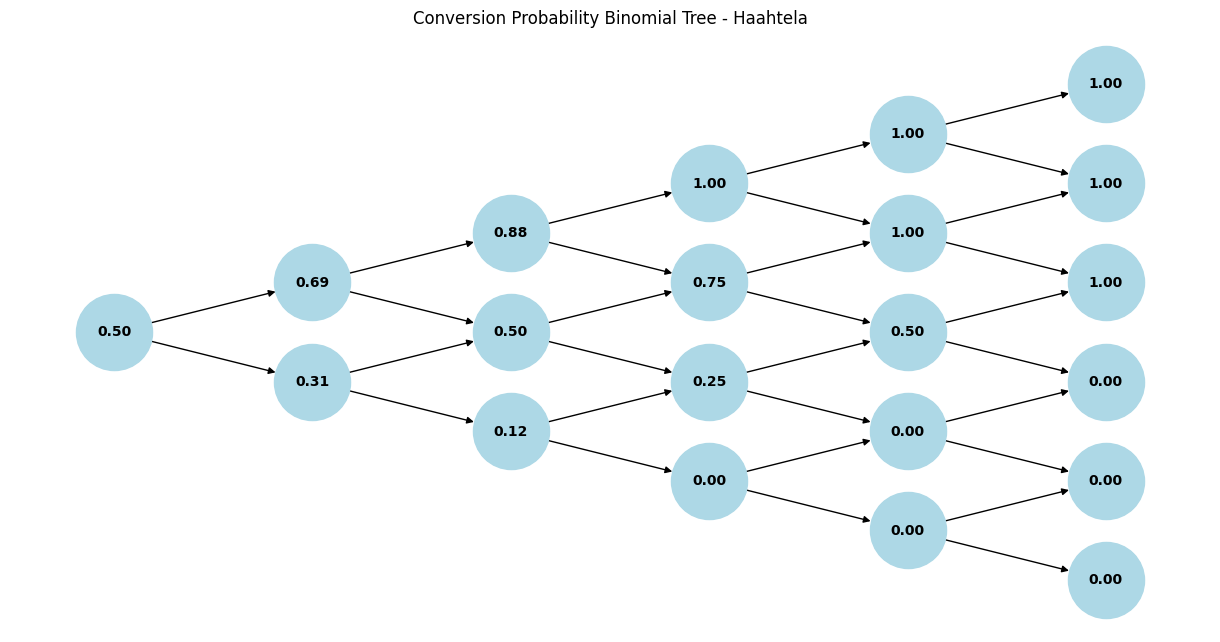

In [3]:
S0 = 75                             # Initial stock price
F = 100                             # Face value of the bond
X = 100                             # Strike price for conversion
T = 5                               # Time to maturity (in years)
t1= 0
r = 0.07                            # Risk-free rate
q = 0
b = r - q
k = 0.03                            # Credit spread
sigma = 0.2                         # Volatility
dt = 1
coupon = 6                          # Coupon payment per year
m = 1                               # Conversion ratio (1 bond = 1 stock)
N = 5                              # Number of time steps
conversion_ratio = F / X            # Conversion ratio

# Function to calculate tree parameters (u, d, p) for different models
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
    elif model_type == 'CRR_Drift':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r + drift) * dt) - d) / (u - d)
    elif model_type == 'Jarrow-Rudd':
        u = np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt))
        d = np.exp((r - q - 0.5 * sigma ** 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif model_type == 'Tian':
        eta=np.exp(dt*sigma**2)
        u=0.5*np.exp(r*dt)*eta*(eta+1+np.sqrt(eta**2+2*eta-3))
        d=0.5*np.exp(r*dt)*eta*(eta+1-np.sqrt(eta**2+2*eta-3))
        p=(np.exp((b)*dt)-d)/(u-d)
    elif model_type == 'Haahtela':
        u = np.exp(r * dt) * (1 + np.sqrt(np.exp((sigma ** 2) * dt) - 1))
        d = np.exp(r * dt) * (1 - np.sqrt(np.exp((sigma ** 2) * dt) - 1))
        p = (np.exp((r - q) * dt) - d) / (u - d)
    else:
        raise ValueError("Unknown model type provided.")

    return u, d, p

def LatticeConvertibleBond(S0, F, T, r, k, coupon, conversion_ratio, N, model_type='', AmeEur='a', q=0, drift=0):
    dt = T / N  # Time step
    sigma = 0.2  # Assume a constant volatility for demonstration purposes

    # Calculate u, d, p using the specified model type
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Create the binomial stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    BondPrice = np.zeros((N + 1, N + 1))
    # Create the conversion probability tree
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(N + 1):
        stock_price = StockPrice[j, N]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        BondPrice[j, N] = bond_value_at_maturity
        ConversionProbability[j, N] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(N - 1, -1, -1):
        if CouponTime != (T - np.ceil((N - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((N - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = StockPrice[j, i]

            # Dynamic discount factors (ru, rd)
            ru = ConversionProbability[j+1, i+1] * r + (1 - ConversionProbability[j+1, i+1]) * (r + k)
            rd = ConversionProbability[j, i+1] * r + (1 - ConversionProbability[j, i+1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            hold_bond_value = CouponValue + p * BondPrice[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * BondPrice[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Modify for American or European option style
            if AmeEur == 'a':  # American option: can convert at any time
                BondPrice[j, i] = max(hold_bond_value, convert_to_stock_value)

            else:  # European option: can only convert at maturity
                BondPrice[j, i] = hold_bond_value

            # Update the conversion probability based on the style
            if AmeEur == 'a' and BondPrice[j, i] == convert_to_stock_value:
                ConversionProbability[j, i] = 1
            else:
                ConversionProbability[j, i] = p * ConversionProbability[j + 1, i + 1] + (1 - p) * ConversionProbability[j, i + 1]

    return StockPrice, BondPrice, ConversionProbability

# Function to plot a binomial tree
def plot_binomial_tree(tree, title):
    N = tree.shape[1] - 1
    G = nx.DiGraph()
    pos = {}
    labels = {}
    
    for i in range(N + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  
            labels[node] = f"{tree[j, i]:.2f}"
            if i < N:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()
    
    # Function to create and plot trees for each model
def create_and_plot_trees(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, N, model_type):
    for model in model_type:
        print(f"\n=== Model: {model} ===")

        # Calculate parameters of the model
        u, d, p = calculate_tree_parameters(r, q, sigma, T/N, model)

        # Print the computed parameters
        print(f"Model: {model}, u: {u:.4f}, d: {d:.4f}, p: {p:.4f}")  

        # Compute and plot the results
        StockPrice, BondPrice, ConversionProbability = LatticeConvertibleBond(S0, F, T, r, k, coupon, conversion_ratio, N, model)

        # Plot Stock Price Tree
        plot_binomial_tree(StockPrice, f"Stock Price Binomial Tree - {model}")

        # Plot Bond Price Tree
        plot_binomial_tree(BondPrice, f"Convertible Bond Price Binomial Tree - {model}")

        # Plot Conversion Probability Tree
        plot_binomial_tree(ConversionProbability, f"Conversion Probability Binomial Tree - {model}")

# Define models to be plotted
model_type = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela']

# Generate and plot the trees
create_and_plot_trees(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, N, model_type)


In [4]:

StockPrice, BondPrice, ConversionProbability = LatticeConvertibleBond(
    S0, F, T, r, k, coupon, conversion_ratio, N, model_type='Tian', AmeEur='e'
)
OptionValue= BondPrice[0, 0]
print(f"Option value at t=0: {OptionValue}")


Option value at t=0: 108.1869030007444


### Convergence of Convertible Bond Price Binomial Tree for Different Models

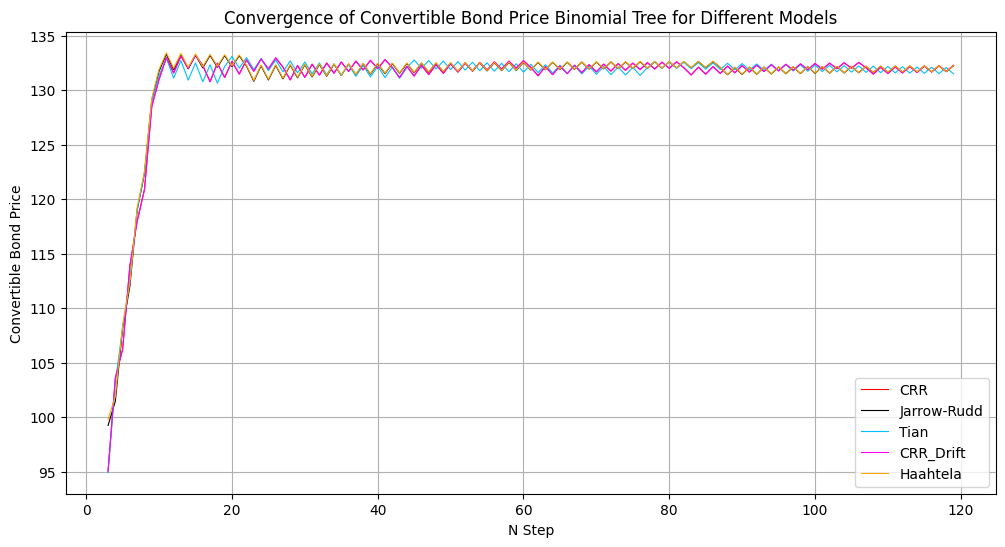

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Using the exact logic from Code Block A for consistent results
def getPrice_LatticeModel(S0, F, T, r, k, coupon, conversion_ratio, N, model_type, q=0, drift=0):
    dt = T / N  # Time step
    sigma = 0.2  # Assume a constant volatility for demonstration purposes

    # Calculate u, d, p using the specified model type
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Create the binomial stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price and conversion probability trees
    BondPrice = np.zeros((N + 1, N + 1))
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calculate bond values and conversion probabilities at maturity
    for j in range(N + 1):
        stock_price = StockPrice[j, N]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        BondPrice[j, N] = bond_value_at_maturity
        ConversionProbability[j, N] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(N - 1, -1, -1):
        if CouponTime != (T - np.ceil((N - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((N - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = StockPrice[j, i]

            # Dynamic discount factors (ru, rd)
            ru = ConversionProbability[j + 1, i + 1] * r + (1 - ConversionProbability[j + 1, i + 1]) * (r + k)
            rd = ConversionProbability[j, i + 1] * r + (1 - ConversionProbability[j, i + 1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            hold_bond_value = CouponValue + p * BondPrice[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * BondPrice[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Modify for American or European option style
            BondPrice[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Update the conversion probability
            ConversionProbability[j, i] = 1 if BondPrice[j, i] == convert_to_stock_value else p * ConversionProbability[j + 1, i + 1] + (1 - p) * ConversionProbability[j, i + 1]

    return BondPrice[0, 0]

# Input parameters for the bond
S0 = 75                     # Initial stock price
F = 100                     # Face value of the bond
X = 100                     # Strike price for conversion
T = 5                       # Time to maturity in years
r = 0.07                    # Risk-free rate
k = 0.03                    # Credit spread
coupon = 6                  # Annual coupon payment
conversion_ratio = F / X    # Conversion ratio
min_step = 3                # Minimum number of steps in the tree
max_step = 120              # Maximum number of steps in the tree

# Define the list of models to include in the plot
model_types = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela']

# Initialize a dictionary to store the bond prices for each model
results = {model: np.zeros([max_step - min_step]) for model in model_types}

# Loop through each model and calculate the bond price for varying steps
for model in model_types:
    j = 0
    for i in np.arange(min_step, max_step):
        # Calculate bond price for the given number of steps using the modified function
        results[model][j] = getPrice_LatticeModel(S0, F, T, r, k, coupon, conversion_ratio, i, model)
        j += 1

# Create a plot for convergence
plt.figure(figsize=(12, 6))

# Define a color scheme for each model
colors = {
    'CRR': 'red',
    'Jarrow-Rudd': 'black',
    'Tian': 'deepskyblue',
    'CRR_Drift': 'magenta',
    'Haahtela': 'orange'
}

# Plot each model with its respective color and label
for model in model_types:
    plt.plot(range(min_step, max_step), results[model], label=model, color=colors[model], linewidth=0.8)

# Add labels and title
plt.xlabel("N Step")
plt.ylabel("Convertible Bond Price")
plt.title("Convergence of Convertible Bond Price Binomial Tree for Different Models")
plt.legend()
plt.grid(True)
plt.show()

### Convergence of Convertible Bond Price Binomial Tree for CRR Model

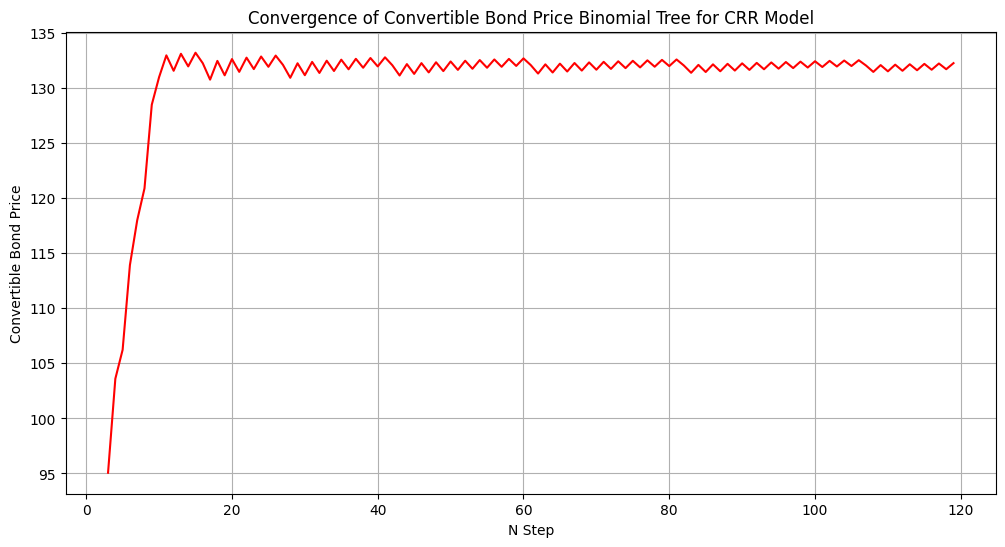

In [11]:
# Input parameters for the bond
min_step = 3      # Minimum number of steps in the tree
max_step = 120    # Maximum number of steps in the tree

# Define the list of models to include in the plot
model_types = ['CRR']

# Initialize a dictionary to store the bond prices for each model
results = {model: np.zeros([max_step - min_step]) for model in model_types}

# Loop through each model and calculate the bond price for varying steps
for model in model_types:
    j = 0
    for i in np.arange(min_step, max_step):
        # Calculate bond price for the given number of steps using the modified function
        results[model][j] = getPrice_LatticeModel(S0, F, T, r, k, coupon, conversion_ratio, i, model)
        j += 1

# Create a plot for convergence
plt.figure(figsize=(12, 6))

# Define a color scheme for each model
colors = {
    'CRR': 'red'
}

# Plot each model with its respective color and label
for model in model_types:
    plt.plot(range(min_step, max_step), results[model], label=model, color=colors[model])

# Add labels and title
plt.xlabel("N Step")
plt.ylabel("Convertible Bond Price")
plt.title("Convergence of Convertible Bond Price Binomial Tree for CRR Model")
plt.grid(True)
plt.show()